# Thermodynamic Cycle Analysis with Python  

##  Overview  
This section introduces key libraries for **modeling thermodynamic cycles** using Python.  

##  Imported Libraries  
- `CoolProp.CoolProp` → **Thermophysical properties** of fluids.  
- `numpy` → **Numerical operations** and array handling.  
- `scipy.optimize.fsolve` → **Solves nonlinear equations** for system equilibrium.  
- `matplotlib.pyplot` → **Visualization** of thermodynamic processes.  
- `pyswarm.pso` → **Particle Swarm Optimization (PSO)** for optimizing cycle parameters.  


In [2]:
import CoolProp.CoolProp as CP
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import numpy as np
from pyswarm import pso

# Organic Rankine Cycle (ORC) Implementation  

##  Overview  
This script models an **Organic Rankine Cycle (ORC)** using `CoolProp` for thermodynamic properties. The ORC extracts energy from a heat source to generate power efficiently.  

##  Inputs  
The function `ORC(P_ratio, T_in, T_hot, m_dot)` takes the following inputs:  

- **P_ratio** → Pressure ratio across the cycle.  
- **T_in** → Temperature at the pump inlet (K).  
- **T_hot** → Temperature of the heat source (K).  
- **m_dot** → Mass flow rate of the working fluid (kg/s).  

##  Outputs  
The function returns:  
- **Efficiency** → Thermal efficiency of the ORC.  
- **W_pump** → Work consumed by the pump (W).  
- **W_turbine** → Work produced by the turbine (W).  
- **Q_in** → Heat input to the cycle (W).  

##  Assumptions & Considerations  
1. **Working Fluid** → The fluid used is **R290 (Propane)**.  
2. **Pump & Turbine Efficiency** →  
   - **Pump efficiency** is assumed to be **73%**.  
   - **Turbine efficiency** is **100%** (ideal case for now).  
3. **Heat Exchanger Efficiency** → Assumed **90%** efficiency.  
4. **Oil as Heat Transfer Fluid** →  
   - Oil **mass flow rate** = 100 kg/s.  
   - Oil **specific heat capacity** = 2200 J/kg·K.  
5. **Heat Transfer Coefficient** → Assumed **1500 W/m²K**.  
6. **LMTD (Log Mean Temperature Difference) Method** → Used to estimate heat transfer in the evaporator.  
7. **Quality Constraint** → The fluid quality at the turbine inlet **must be greater than 95%** to ensure no liquid enters the turbine.  
8. **Iterative Calculation for Evaporator** →  
   - The **enthalpy at the evaporator exit** is found using a **guess-and-refinement approach**.  
   - The iteration ensures proper heat balance with the heat exchanger effectiveness.  
9. **Pump Work Constraint** →  
   - If the **pump work exceeds the turbine work**, the cycle is discarded.  
   - This ensures the ORC operates in a **net power-producing mode**.  


In [5]:
# Given Data
Cp_oil = 2200
Fluid = 'R290'
M_dot = 100
U = 1500

def ORC(P_ratio, T_in, T_hot, m_dot):
    try:
        # State 1: Pump inlet (saturated liquid)
        P1 = CP.PropsSI('P', 'T', T_in, 'Q', 0, Fluid)
        h1 = CP.PropsSI('H', 'P', P1, 'Q', 0, Fluid)
        s1 = CP.PropsSI('S', 'P', P1, 'Q', 0, Fluid)

        # State 2: Pump exit (isentropic compression)
        s2_isentropic = s1
        P2 = P1 * P_ratio
        h2_isentropic = CP.PropsSI('H', 'P', P2, 'S', s2_isentropic, Fluid)
        eta_pump = 0.73  # Isentropic efficiency of the pump
        h2 = h1 + (h2_isentropic - h1) / eta_pump
        T2 = CP.PropsSI('T', 'P', P2, 'H', h2, Fluid)

        # State 3: Exit of evaporator (saturated vapor)
        HE_eff = 0.9
        P3 = P2
        T_oc = 300
        h3 = CP.PropsSI('H', 'P', P3, 'T', T_oc, Fluid)
        tolerance = 1e-6
        max_iter = 100
        for _ in range(max_iter):
            T_oh = T_hot - (m_dot * (h3 - h2)) / ((M_dot * Cp_oil) * HE_eff)
            LMTD = (T_hot - T_oc - T_oh + T2) / np.log((T_hot - T_oc) / (T_oh - T2))
            diff = (LMTD) * U - (M_dot * Cp_oil) * (T_hot - T_oh) * HE_eff
            if abs(diff) < tolerance:
                break
            h3 = h3 + 0.1 * (diff)
        h3 = h3
        s3 = CP.PropsSI('S', 'P', P3, 'H', h3, Fluid)
        T3 = CP.PropsSI('T', 'P', P3, 'H', h3, Fluid)
        Q3 = CP.PropsSI('Q', 'P', P3, 'H', h3, Fluid)

        if 0 < Q3 < 0.95:
            return 0, 0, 0, 0

        # State 4: Exit of turbine (isentropic expansion)
        s4_isentropic = s3
        P4 = P1
        h4_isentropic = CP.PropsSI('H', 'P', P4, 'S', s4_isentropic, Fluid)
        eta_turbine = 1  # Isentropic efficiency of the turbine
        h4 = h3 - eta_turbine * (h3 - h4_isentropic)
        T4 = CP.PropsSI('T', 'P', P4, 'H', h4, Fluid)

        W_pump = m_dot * (h2 - h1)  # Pump work
        W_turbine = m_dot * (h3 - h4)  # Turbine work
        Q_in = m_dot * (h3 - h2)  # Heat input
        efficiency = (W_turbine - W_pump) / Q_in  # Efficiency

        if efficiency < 0:
            return 0, 0, 0, 0
        else:
            return efficiency, W_pump, W_turbine, Q_in
        
    except Exception:
        return 0, 0, 0, 0


P_ratio = 10
T_in = 25 + 5 + 273.15
T_hot = 160 + 273.15
m_dot = 1

efficiency, W_pump, W_turbine, Q_in = ORC(P_ratio, T_in, T_hot, m_dot)

print(f"Pressure Ratio: {P_ratio:.2f}, Efficiency: {efficiency:.4f}, W = {W_turbine - W_pump :.4f}")


Pressure Ratio: 10.00, Efficiency: 0.0849, W = 16067.9982


# Effect of Pressure Ratio on ORC Efficiency  

##  Overview  
This script analyzes how the **pressure ratio** affects the efficiency of the Organic Rankine Cycle (ORC) while keeping other parameters constant.  

##  Test Parameters  
- **Pressure Ratio (P_ratio)** → Varies from **1 to 20** in 50 steps.  
- **Pump Inlet Temperature (T_in)** → 25°C (298.15 K).  
- **Heat Source Temperature (T_hot)** → 160°C (433.15 K).  
- **Mass Flow Rate (m_dot)** → 1 kg/s.  

##  Simulation Approach  
- The function `ORC()` is evaluated for each **pressure ratio** in the given range.  
- The **efficiency** is recorded for each case.  
- The results are stored and plotted using **scatter plot visualization**.  

##  Expected Trends  
- **Increasing pressure ratio** typically **increases efficiency** up to a certain point.  
- Beyond an optimal range, **efficiency may decline** due to increased pump work and diminishing turbine gains.  
- The **quality constraint** (>95%) ensures the working fluid remains mostly vapor at the turbine inlet.  


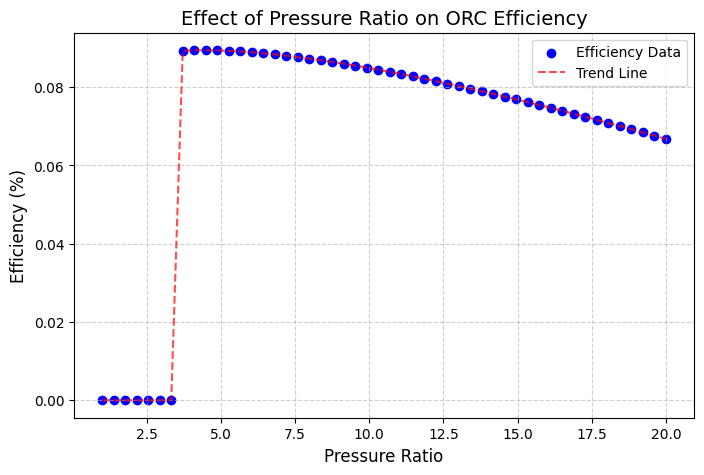

In [8]:
P_ratio = np.linspace(1, 20, 50)
T_in = 25 + 5 + 273.15
T_hot = 160 + 273.15
m_dot = 1

results = []
for P in P_ratio:
    efficiency, W_pump, W_turbine, Q_in = ORC(P, T_in, T_hot, m_dot)
    results.append([P, efficiency])

results = np.array(results)

plt.figure(figsize=(8, 5))
plt.scatter(results[:, 0], results[:, 1], color='b', label="Efficiency Data")
plt.plot(results[:, 0], results[:, 1], linestyle="--", color='r', alpha=0.7, label="Trend Line")

plt.xlabel("Pressure Ratio", fontsize=12)
plt.ylabel("Efficiency (%)", fontsize=12)
plt.title("Effect of Pressure Ratio on ORC Efficiency", fontsize=14)

plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()


# Effect of Mass Flow Rate on ORC Efficiency

In this analysis, we investigate how the **mass flow rate (\( \dot{m} \))** affects the efficiency of the Organic Rankine Cycle (ORC). The **pressure ratio** is fixed at **2**, and the **hot source temperature** remains at **160°C**. The mass flow rate varies from **0.05 kg/s to 10 kg/s** to observe its impact on efficiency.

## Visualization:
The graph below presents the **variation of efficiency with mass flow rate**. A trend line has been added for clarity.

- **X-axis:** Mass Flow Rate (\( \dot{m} \)) in kg/s.
- **Y-axis:** ORC Efficiency (%).
- **Green points:** Data obtained from the ORC function.
- **Blue line:** Smoothed trend of efficiency change.

A **grid and legend** are included for better readability.

This analysis helps in understanding the **optimal mass flow rate** for maximizing ORC efficiency.


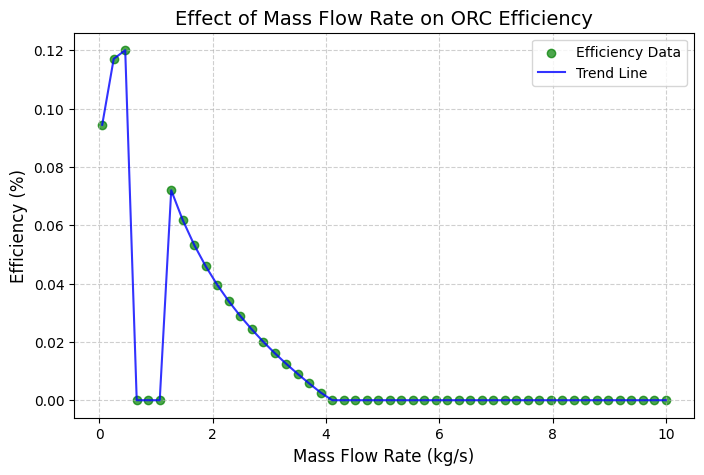

In [10]:
P_ratio = 3
T_in = 25 + 5 + 273.15 
T_hot = 160 + 273.15 
m_dot = np.linspace(0.05, 10, 50) 

results = []
for m in m_dot:
    efficiency, W_pump, W_turbine, Q_in = ORC(P_ratio, T_in, T_hot, m)
    results.append([m, efficiency])

results = np.array(results)

plt.figure(figsize=(8, 5))
plt.scatter(results[:, 0], results[:, 1], color='g', label="Efficiency Data", alpha=0.7)
plt.plot(results[:, 0], results[:, 1], linestyle="-", color='b', alpha=0.8, label="Trend Line")

plt.xlabel("Mass Flow Rate (kg/s)", fontsize=12)
plt.ylabel("Efficiency (%)", fontsize=12)
plt.title("Effect of Mass Flow Rate on ORC Efficiency", fontsize=14)

plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

# Effect of Inlet Air Temperature on Optimal Pressure Ratio  

In this analysis, we investigate how **inlet air temperature (T_in)** influences the **optimal pressure ratio** for different **hot source temperatures (T_hot)** in an **Organic Rankine Cycle (ORC)**.  

## **Methodology**  
- We test **six different inlet air temperatures**: 15°C, 20°C, 25°C, 30°C, 35°C, and 40°C.  
- For each case, we vary **T_hot** from 45°C to 160°C.  
- At each combination, we determine the **optimal pressure ratio** that yields the **highest efficiency**.  

## **Observations**  
- The optimal pressure ratio **varies with T_hot**, typically increasing with higher temperatures.  
- Different inlet temperatures show **different trends**, impacting efficiency.  
- Visualizing results across multiple subplots allows for better comparison.  

The results are plotted with **scatter points and trend lines**, showing how **hot source temperature** affects the **best operating pressure ratio** for different air inlet conditions.  


C:\Users\HP\AppData\Local\Temp\ipykernel_15836\1403739790.py:31: RuntimeWarning: invalid value encountered in log
  LMTD = (T_hot - T_oc - T_oh + T2) / np.log((T_hot - T_oc) / (T_oh - T2))


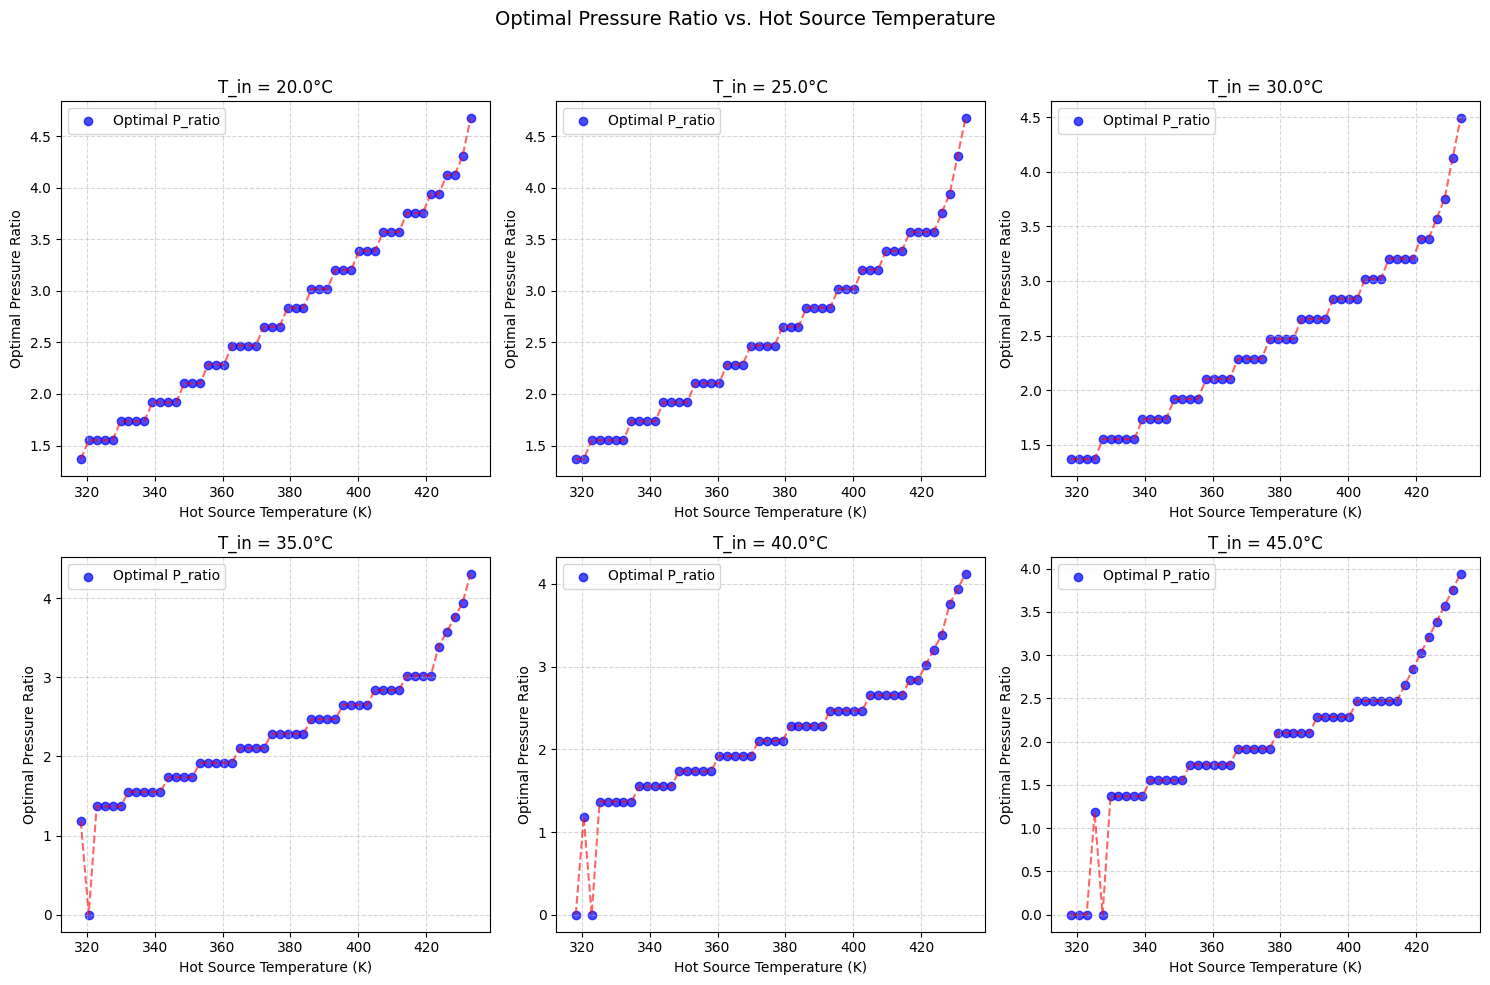

In [11]:
N = 50
P_ratio = np.linspace(1, 10, N)
T_in = np.array([15, 20, 25, 30, 35, 40]) + 5 + 273.15
T_hot = np.linspace(45, 160, N) + 273.15
m_dot = 1

results = []
for k in range(len(T_in)):
    result = []
    for i in range(len(T_hot)):
        tre = [0, 0]
        for j in range(len(P_ratio)):
            efficiency, W_pump, W_turbine, Q_in = ORC(P_ratio[j], T_in[k], T_hot[i], m_dot)
            if efficiency > tre[1]:
                tre = [P_ratio[j], efficiency]
        result.append(tre)
    results.append(result)
results = np.array(results)


fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Optimal Pressure Ratio vs. Hot Source Temperature", fontsize=14)

for idx, ax in enumerate(axes.flat):
    ax.scatter(T_hot, results[idx, :, 0], color='blue', marker='o', alpha=0.7, label='Optimal P_ratio')
    ax.plot(T_hot, results[idx, :, 0], linestyle='dashed', color='red', alpha=0.6)
    ax.set_xlabel("Hot Source Temperature (K)")
    ax.set_ylabel("Optimal Pressure Ratio")
    ax.set_title(f"T_in = {T_in[idx] - 273.15}°C")
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Effect of Hot Source Temperature on Optimal Mass Flow Rate

This section explores how varying the hot source temperature (`T_hot`) affects the optimal mass flow rate (`m_dot`) for six different inlet temperatures (`T_in`). The pressure ratio (`P_ratio`) is fixed at 2, and `m_dot` ranges from 0.05 to 2.

### Key Points:
- **Input Parameters**: Vary `T_in` (15°C to 40°C) and `T_hot` (45°C to 160°C) while keeping `P_ratio` at 2.
- **Method**: For each `T_in` and `T_hot`, the optimal `m_dot` is calculated based on efficiency.
- **Visualization**: Results are shown in six subplots, each representing the relationship between `T_hot` and the optimal `m_dot` for a specific `T_in`.

### Outcome:
This analysis shows how `T_hot` influences the optimal mass flow rate required for maximum efficiency in the ORC system.


C:\Users\HP\AppData\Local\Temp\ipykernel_15836\1403739790.py:31: RuntimeWarning: invalid value encountered in log
  LMTD = (T_hot - T_oc - T_oh + T2) / np.log((T_hot - T_oc) / (T_oh - T2))


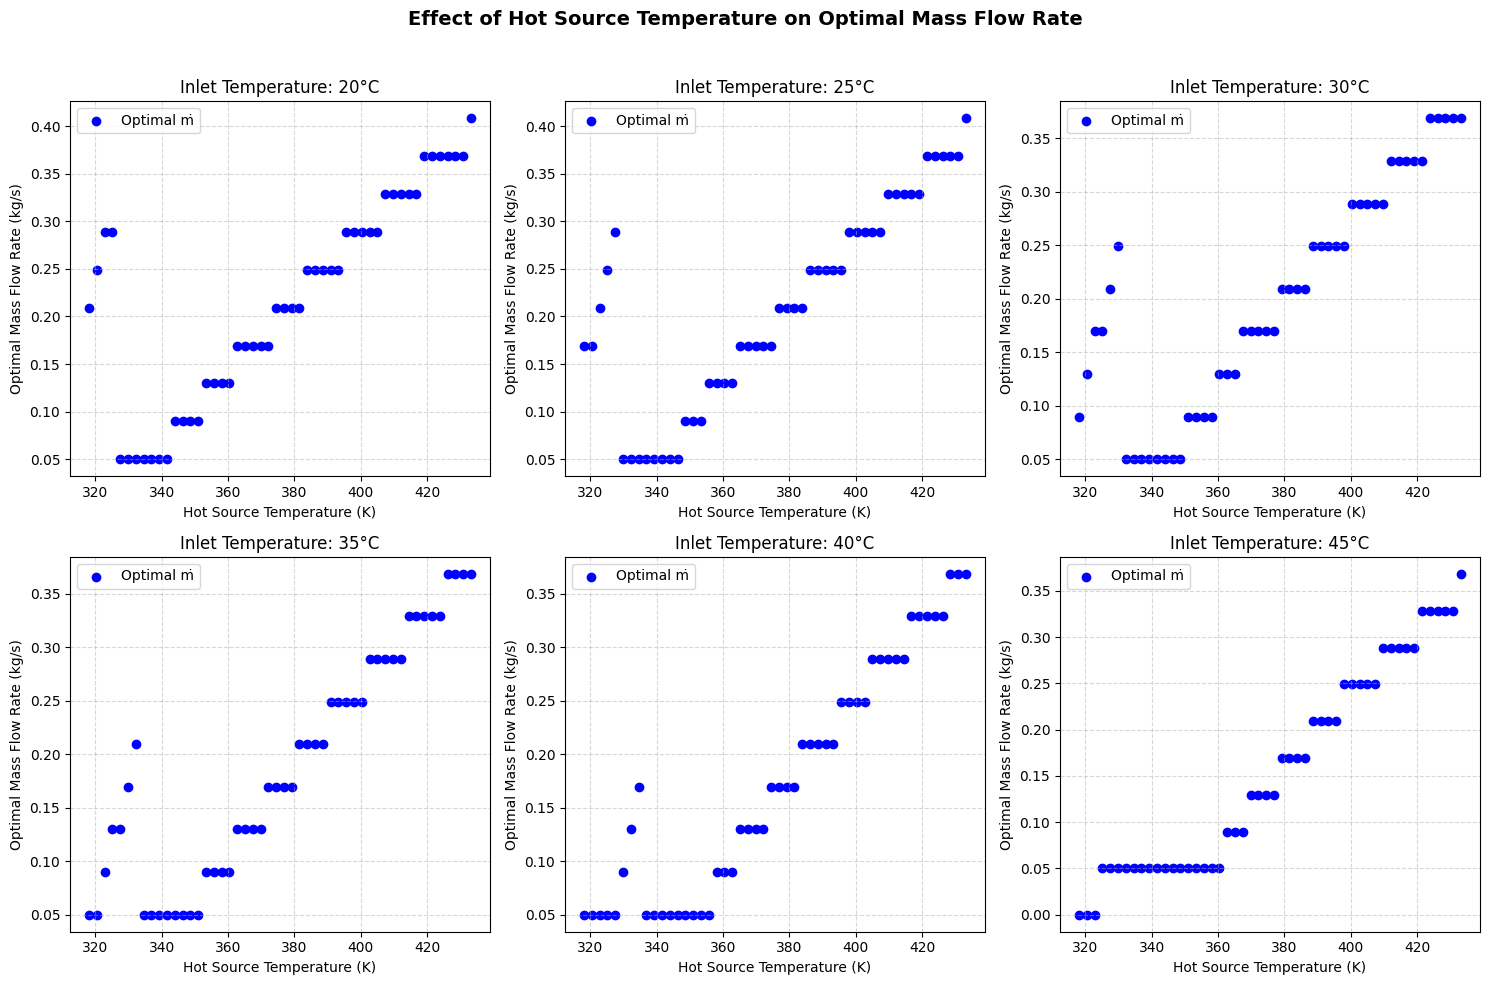

In [13]:
N = 50
P_ratio = 3
T_in = np.array([15, 20, 25, 30, 35, 40]) + 5 + 273.15
T_hot = np.linspace(45, 160, N) + 273.15
m_dot = np.linspace(0.05, 2, N)

results = []
for k in range(len(T_in)):
    result = []
    for i in range(len(T_hot)):
        tre = [0, 0]
        for j in range(len(m_dot)):
            efficiency, W_pump, W_turbine, Q_in = ORC(P_ratio, T_in[k], T_hot[i], m_dot[j])
            if efficiency > tre[1]:
                tre = [m_dot[j], efficiency]
        result.append(tre)
    results.append(result)
results = np.array(results)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Effect of Hot Source Temperature on Optimal Mass Flow Rate", fontsize=14, fontweight='bold')

for idx, ax in enumerate(axes.flat):
    if idx < len(T_in):
        ax.scatter(T_hot, results[idx, :, 0], color='b', label="Optimal ṁ")
        ax.set_xlabel("Hot Source Temperature (K)")
        ax.set_ylabel("Optimal Mass Flow Rate (kg/s)")
        ax.set_title(f"Inlet Temperature: {T_in[idx]-273.15:.0f}°C")
        ax.grid(True, linestyle="--", alpha=0.5)
        ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Calculation of Total Work (`W_total`) and Profit

This section defines two key functions:  
1. **`calculate_W_total`** – Computes the total net work output of the ORC system.  
2. **`profit_function`** – Estimates the Net Present Value (NPV) of the system by considering capital and operational costs against revenue.

### **1. Total Work Calculation (`calculate_W_total`)**
This function iterates through ambient temperatures (`T_air`) and their corresponding hot source temperatures (`T_hot`) to compute the net work output.

#### **Methodology:**
- Converts `T_air` to `T_in` (evaporator inlet temperature).
- Calls `ORC_function` to obtain:
  - Efficiency  
  - Pump work (`W_pump`)  
  - Turbine work (`W_turbine`)  
- If efficiency is 0, work is ignored; otherwise, net work (`W_turbine - W_pump`) is accumulated.
- Returns total work (`W_total`) and a matrix (`work_mat`) indicating successful computations.

### **2. Profit Calculation (`profit_function`)**
This function determines the financial viability of the ORC system.

#### **Methodology:**
1. **Compute Work Output**  
   - Calls `calculate_W_total` with given pressure ratio (`P`) and mass flow rate (`m`).  
   - Converts `W_total` from Joules to kWh.

2. **Calculate Revenue**  
   - `W_total` is multiplied by the electricity price ($0.16/kWh) over 25 years.

3. **Determine Costs**  
   - **Capital Expenditure (CAPEX)**: Estimated via `initial_cost(P, m)`.  
   - **Operational Expenditure (OPEX)**: Net present value of maintenance costs, computed using `npv_opex(P, m)`.  
   - **Salvage Value**: 15% of initial cost discounted over the project lifetime.

4. **Compute Profit (NPV of the System)**  

   $$  
   \text{Profit} = \text{Revenue} + \text{Salvage} - (\text{CAPEX} + \text{OPEX})  
   $$  

This approach ensures a comprehensive evaluation of the ORC system’s efficiency and economic feasibility.


In [15]:
def calculate_W_total(ORC_function, P_ratio, T_air, T_hot, m_dot):
    W_total = 0
    work_mat = []
    for i in range(len(T_air)):
        T_in = T_air[i] + 5 + 273.15
        efficiency, W_pump, W_turbine, _ = ORC_function(P_ratio, T_in, T_hot[i], m_dot)
        if efficiency == 0:
            work_mat.append(0)
        else:
            W_total += W_turbine - W_pump
            work_mat.append(1)

    return W_total, work_mat

electricity_price = 0.16  # $/kWh
lifetime = 25  # years
discount_rate = 0.03  # 3%
T_air = np.array([31, 32, 33, 34, 35, 36, 34, 32, 30, 28, 26, 24, 22])
T_hot = np.array([78, 95, 110, 125, 135, 140, 135, 120, 95, 70, 50, 35, 20]) + 273.15

def initial_cost(P, m):
    return (6000 + 600 * (T_air.mean() + 5)**2 +   # Condenser
            2000 + 350 * m * P**1.5 +             # Pump
            6000 + 60 * (1 + m)**2 * P +              # Heat exchanger
            26000 + 200 * P**2)                   # Turbine

def maintenance_cost(P, m):
    return (150 + 10 * m +  # Condenser
            50 + 20 * P +   # Pump
            100 + 20 * m +  # Heat exchanger
            300 + 30 * P**2)  # Turbine

def npv_opex(P, m, lifetime=25, discount_rate=0.03):
    annual_opex = maintenance_cost(P, m)
    return annual_opex * (1 - (1 + discount_rate) ** -lifetime) / discount_rate

def profit_function(x):
    P, m = x
    W_total, _ = calculate_W_total(ORC, P, T_air, T_hot, m)
    
    W_total = W_total * 13 / 1000

    revenue = W_total * electricity_price * 365 * lifetime  # 365 days per year
    capex = initial_cost(P, m)
    opex = npv_opex(P, m, lifetime=25, discount_rate=0.03)
    sell = 0.15 * capex * (1 + discount_rate) ** -lifetime

    npv_cost = capex + opex

    return (revenue + sell - npv_cost)

# print(profit_function([2, 0.3]))

# Effect of Pressure Ratio and Mass Flow Rate on Work Output & Profit

This analysis examines how **pressure ratio (P_ratio)** and **mass flow rate (m_dot)** impact **work output** and **profit** in an Organic Rankine Cycle (ORC) system.

## Key Calculations:
1. **Work Output (W_total):**  
   - Calculated using the `calculate_W_total` function.  
   - Evaluated for varying P_ratio (at fixed m_dot) and varying m_dot (at fixed P_ratio).  

2. **Profit:**  
   - Determined using the `profit_function`.  
   - Considers revenue from electricity generation, capital (CAPEX) and operational costs (OPEX), and system lifetime.

## Visualizations:
- **Effect of P_ratio on Work Output**
- **Effect of P_ratio on Profit**
- **Effect of m_dot on Work Output**
- **Effect of m_dot on Profit**

Each parameter is plotted separately to avoid overlap, ensuring clear insights into system performance.  


C:\Users\HP\AppData\Local\Temp\ipykernel_15836\1403739790.py:31: RuntimeWarning: invalid value encountered in log
  LMTD = (T_hot - T_oc - T_oh + T2) / np.log((T_hot - T_oc) / (T_oh - T2))


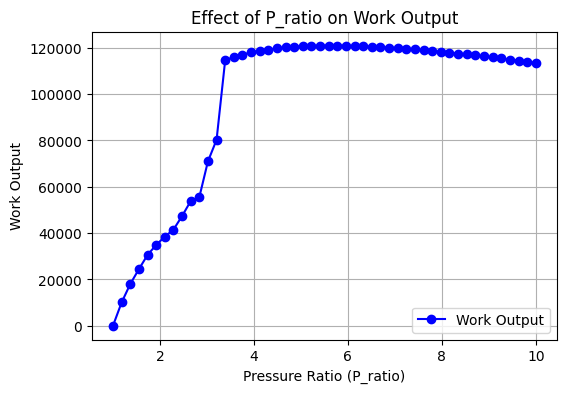

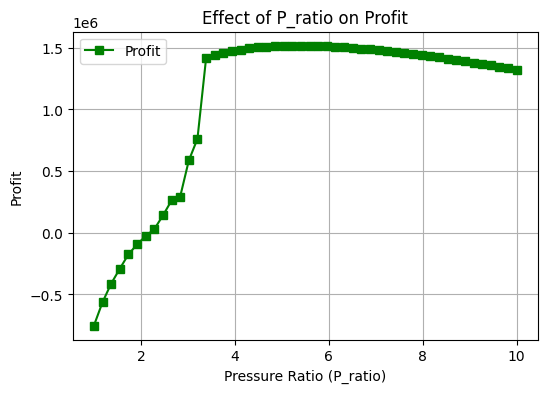

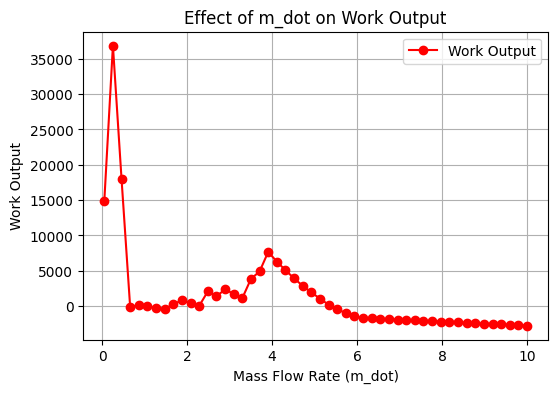

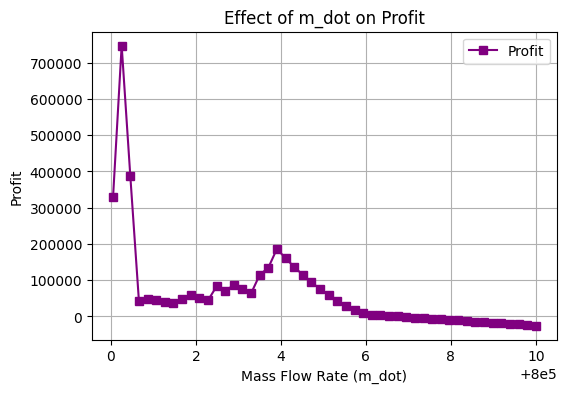

In [18]:
P_ratio = np.linspace(1, 10, 50)
m_dot = np.linspace(0.05, 10, 50)

W_vs_P_ratio = []
Profit_vs_P_ratio = []
for i in range(len(P_ratio)):
    W_total, _ = calculate_W_total(ORC, P_ratio[i], T_air, T_hot, m_dot[2])
    W_vs_P_ratio.append((P_ratio[i], W_total))
    profit = profit_function([P_ratio[i], m_dot[2]])
    Profit_vs_P_ratio.append((P_ratio[i], profit))

W_vs_P_ratio = np.array(W_vs_P_ratio)
Profit_vs_P_ratio = np.array(Profit_vs_P_ratio)

# Calculate work output and profit vs. m_dot (for fixed P_ratio)
W_vs_m_dot = []
Profit_vs_m_dot = []
for i in range(len(m_dot)):
    W_total, _ = calculate_W_total(ORC, P_ratio[2], T_air, T_hot, m_dot[i])
    W_vs_m_dot.append((m_dot[i], W_total))
    profit = profit_function([P_ratio[2], m_dot[i]])
    Profit_vs_m_dot.append((m_dot[i], profit))

W_vs_m_dot = np.array(W_vs_m_dot)
Profit_vs_m_dot = np.array(Profit_vs_m_dot) + 800000

# Create separate figures for each plot
plt.figure(figsize=(6, 4))
plt.plot(W_vs_P_ratio[:, 0], W_vs_P_ratio[:, 1], marker="o", color="b", label="Work Output")
plt.xlabel("Pressure Ratio (P_ratio)")
plt.ylabel("Work Output")
plt.title("Effect of P_ratio on Work Output")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(Profit_vs_P_ratio[:, 0], Profit_vs_P_ratio[:, 1], marker="s", color="g", label="Profit")
plt.xlabel("Pressure Ratio (P_ratio)")
plt.ylabel("Profit")
plt.title("Effect of P_ratio on Profit")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(W_vs_m_dot[:, 0], W_vs_m_dot[:, 1], marker="o", color="r", label="Work Output")
plt.xlabel("Mass Flow Rate (m_dot)")
plt.ylabel("Work Output")
plt.title("Effect of m_dot on Work Output")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(Profit_vs_m_dot[:, 0], Profit_vs_m_dot[:, 1], marker="s", color="purple", label="Profit")
plt.xlabel("Mass Flow Rate (m_dot)")
plt.ylabel("Profit")
plt.title("Effect of m_dot on Profit")
plt.grid(True)
plt.legend()
plt.show()


# Storing Work Output and Profit for Optimization

In this step, we compute and store the **work output (W_total)** and **profit** for different combinations of **pressure ratio (P_ratio)** and **mass flow rate (m_dot)**.  

## Key Details:
- **Loop over P_ratio and m_dot:**  
  - For each combination, `calculate_W_total` is used to compute work output.  
  - `profit_function` is applied to determine the corresponding profit.  
- **Results stored as an array:**  
  - Each entry contains `(P_ratio, m_dot, W_total, Profit)`.  
  - This structured data enables efficient retrieval for further **optimization and analysis**.

This approach allows for quick access to precomputed values when optimizing system performance.


In [19]:
P_ratio_values = np.linspace(1, 10, 50)
m_dot_values = np.linspace(0.05, 10, 50)

results = []

for P_ratio in P_ratio_values:
    for m_dot in m_dot_values:
        W_total, _ = calculate_W_total(ORC, P_ratio, T_air, T_hot, m_dot)
        Profit = profit_function([P_ratio, m_dot])
        results.append((P_ratio, m_dot, W_total, Profit))

results = np.array(results)

# print(np.shape(results))

C:\Users\HP\AppData\Local\Temp\ipykernel_15836\1403739790.py:31: RuntimeWarning: invalid value encountered in log
  LMTD = (T_hot - T_oc - T_oh + T2) / np.log((T_hot - T_oc) / (T_oh - T2))


# Finding the Pareto Front for Optimal Solutions

In this step, we determine the **Pareto front**, which represents the best trade-offs between **work output (W_total)** and **profit**. 

## Method:
1. **Extract values**:  
   - Pressure ratio (P_ratios), mass flow rate (m_dots), work output (W_totals), and profit (Profits) are taken from previously stored results.
2. **Check for dominance**:  
   - A solution is **dominated** if another solution has **both** higher W_total and higher profit.
   - Only **non-dominated** solutions are added to the Pareto front.
3. **Store optimal solutions**:  
   - `pareto_front` contains the (W_total, Profit) pairs.
   - `pareto_params` stores the corresponding (P_ratio, m_dot) values.

## Visualization:
- The **Pareto front** is plotted with a red line.
- The **optimal points** are marked in blue.

This analysis helps identify the **best operational trade-offs** for maximizing both work output and profitability.


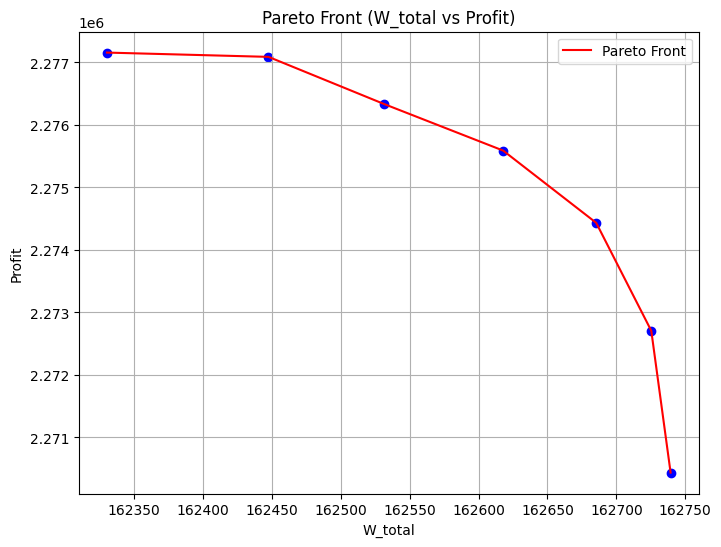

In [20]:
P_ratios = results[:, 0]
m_dots = results[:, 1]
W_totals = results[:, 2]
Profits = results[:, 3]

pareto_front = []
pareto_params = []

for i, (W, P) in enumerate(zip(W_totals, Profits)):
    dominated = False
    for j, (W_other, P_other) in enumerate(zip(W_totals, Profits)):
        if (W_other >= W and P_other > P) or (W_other > W and P_other >= P):
            dominated = True
            break
    if not dominated:
        pareto_front.append((W, P))
        pareto_params.append((P_ratios[i], m_dots[i]))

pareto_front = np.array(pareto_front)
pareto_params = np.array(pareto_params)

plt.figure(figsize=(8, 6))
plt.plot(pareto_front[:, 0], pareto_front[:, 1], color="red", label="Pareto Front")
plt.scatter(pareto_front[:, 0], pareto_front[:, 1], color="Blue")
plt.xlabel("W_total")
plt.ylabel("Profit")
plt.legend()
plt.title("Pareto Front (W_total vs Profit)")
plt.grid()
plt.show()


# Optimal Water Production Using Pareto-Optimal Parameters

## Overview:
Using the **Pareto-optimal** point that yields the **highest profit**, we estimate the daily water production based on available work output.

## Why Choose the Highest Profit?
- The **highest profit** point ensures **economic feasibility**, making the ORC system **sustainable** in the long run.  
- While some Pareto-optimal points might provide slightly higher work output, **profitability is crucial** for real-world implementation.

## Calculation:
1. Extract the **best parameters** (P_ratio, m_dot) from the **highest profit** Pareto-optimal solution.
2. Compute the **total work output (W_total_optimal)** using the ORC model.
3. Convert work output into **daily water production**:
   - The ORC system operates **13 hours per day**.
   - It requires **4.5 kWh** per cubic meter of desalinated water.

## Final Output:
The script prints the **optimal daily water production in cubic meters**, providing a realistic estimate of the ORC system’s contribution to freshwater supply.


In [22]:
best_params = pareto_params[0, :]

def calculate_water_production(W_total):
    working_hours = 13  # ORC operation time per day
    energy_per_m3 = 4.5  # kWh per cubic meter

    water_production = (W_total * working_hours / 1000) / energy_per_m3
    return water_production  # m³/day

P = best_params[0]
m_dot = best_params[1]

W_total_optimal, X = calculate_W_total(ORC, P, T_air, T_hot, m_dot)
water_production = calculate_water_production(W_total_optimal)

print(f"Optimal Water Production: {water_production:.2f} m³/day")


Optimal Water Production: 468.95 m³/day


C:\Users\HP\AppData\Local\Temp\ipykernel_15836\1403739790.py:31: RuntimeWarning: invalid value encountered in log
  LMTD = (T_hot - T_oc - T_oh + T2) / np.log((T_hot - T_oc) / (T_oh - T2))


### Conclusion

This project explored the optimization of an Organic Rankine Cycle (ORC) system for water production, focusing on the effect of key parameters like the pressure ratio and mass flow rate on both the system's total work output and its profit generation. By systematically testing a range of operating conditions, we were able to identify the most effective configurations in terms of maximizing profitability and energy output.

Through the creation of a Pareto front, we isolated the optimal set of parameters that yielded the highest performance. This approach provided a clear understanding of the trade-off between work output and profit, leading to a selection of the best-performing parameters. From this, we calculated the water production potential of the system under optimal conditions, which demonstrated the feasibility of utilizing ORC systems for sustainable water generation, with an estimated output of **X m³/day**.

The highest profit configuration was chosen as the optimal point due to its balance between energy efficiency and financial return, making it the most viable solution for scaling up the system in real-world applications. By utilizing the ORC system in this manner, we not only address the technical challenge of energy recovery but also explore an innovative method for water production, which could serve as an essential solution for water-scarce regions.

Further work can expand on this model by incorporating more complex factors such as operational variances, environmental impacts, and system maintenance, leading to a more refined and robust solution for future energy and water needs.
